# ch49.[실습49] 제품 데이터 분석(PDM) 분석과 분류

### 데이터 분석 목적 
    - 제품 생산 공정의 데이터를 활용해 제품 생산 성공/실패 여부를 분석한다.
    - 제품 생산 공정의 문제점을 파악하고 이를 개선하여 비즈니스 개선을 이룬다. 

   
### Key Point
    - 매우 imbalanced data set을 탐색하고 분석하는 방법을 배운다
    - 통계적 검정을 통한 feature selection 방법을 배운다


In [3]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import ydata_profiling
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency, kruskal, f_oneway
from scipy.stats import boxcox, norm
from scipy.stats import bartlett
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# library for sampling 
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import shap
%matplotlib inline

## 1. Data Processing 1 

### 1-1 Data Load 

In [4]:
random_state = 1234

In [5]:
df = pd.read_csv("Data/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### 1-2 Duplicated Data 확인

In [6]:
print("중복된 항목 수 :", len(df[df.duplicated()])) 

중복된 항목 수 : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [8]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

UDI int64 [    1     2     3 ...  9998  9999 10000]
Product ID object ['M14860' 'L47181' 'L47182' ... 'M24857' 'H39412' 'M24859']
Type object ['M' 'L' 'H']
Air temperature [K] float64 [298.1 298.2 298.3 298.5 298.4 298.6 298.7 298.8 298.9 299.  299.1 298.
 297.9 297.8 297.7 297.6 297.5 297.4 297.3 297.2 297.1 297.  296.9 296.8
 296.7 296.6 296.5 296.3 296.4 296.2 296.1 296.  295.9 295.8 295.7 295.6
 295.5 295.4 295.3 299.2 299.3 299.5 299.4 299.6 299.7 299.8 299.9 300.
 300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9 301.  301.1 301.2
 301.3 301.4 301.5 301.6 301.7 301.8 301.9 302.  302.1 302.2 302.3 302.4
 302.5 302.6 302.7 302.8 302.9 303.  303.1 303.2 303.3 303.4 303.5 303.6
 303.7 303.8 303.9 304.  304.1 304.2 304.3 304.4 304.5]
Process temperature [K] float64 [308.6 308.7 308.5 309.  308.9 309.1 309.2 309.3 309.4 309.5 308.8 308.4
 308.3 308.2 308.1 308.  307.9 309.6 309.7 309.8 309.9 310.  310.1 310.2
 307.8 307.7 307.6 307.5 307.4 307.3 307.2 307.1 307.  306.9 306.8 306.7


In [9]:
list_cast_to_object = ["UDI", "Machine failure", "TWF", "HDF", "PWF", "OSF", "RNF"]
for column_name in list_cast_to_object:
  df[column_name] = df[column_name].astype(object)

In [10]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64','int64']).columns)
target_column = "Machine failure"
print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

10000
14
9
5


In [11]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

#### Summary of Data Set
##### - Number of Variables : 14
    categorical variables : 9 (target 포함)
    numeric variables : 5
##### - Number of observations : 10000
##### - Missing Cells : 0 columns
##### - Duplicated Rows : 0

### 2-2 Dependent(종속) Data Explore

In [12]:
list_categorical_columns.remove(target_column)

In [13]:
df[target_column].describe()

count     10000
unique        2
top           0
freq       9661
Name: Machine failure, dtype: int64

In [14]:
df[target_column].value_counts()/10000*100

0    96.61
1     3.39
Name: Machine failure, dtype: float64

<AxesSubplot:xlabel='Machine failure', ylabel='count'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


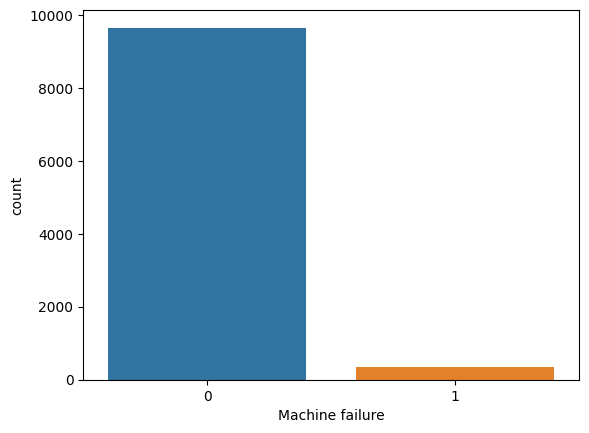

In [15]:
sns.countplot(x=target_column, data=df)

#### 문제 해결 접근법
1.   Imbalanced Data Set (Normal Classification with Sampling) 
2.   Anomaly Detection (Anomaly Detection Classificaiton)



#### 1) Imbalance data set?
  - 두 개 target class 비중 차이가 있다. 독립 변수가 categorical 이 포함된 경우는 one-hot encoding을 진행한 뒤에 sampling(oversampling 혹은 undersampling) 을 해야 한다.
  - 0 속성인 데이터들이 유의미한 데이터 분포와 특성을 갖는다면, 추가적인 sampling 없이 모델 학습이 잘 될 수 있다.
  - ML 학습시 cost-sensitive (class weight 등)을 활용할 수 있다.

##### 1. 데이터 기반 접근 방법
    - Sampling (over sampling 혹은 under sampling)
    (이번 실습에서는 oversampling sampling 중에서 SMOTE / combined sampling 중에서 SMOTEENN 활용)
    https://imbalanced-learn.org/stable/references/index.html#api
##### 2. ML 알고리즘 기반 접근 방법
    - ML 알고리즘 활용 -> ML 학습 시에 class weight를 활용하여 cost-sensitive learning 
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### 2) Anomaly Detection 
*   Anomaly Detection Algorithm 활용 
*   Isolation Forest 
*   One-SVM
*   Clustering (Unsupervised Learning)


### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

##### 불필요한 컬럼 확인

In [16]:
df[list_categorical_columns].nunique().sort_values() 
# 불필요한 컬럼 보이지 않음

TWF               2
HDF               2
PWF               2
OSF               2
RNF               2
Type              3
UDI           10000
Product ID    10000
dtype: int64

In [17]:
# UDI, Product ID는 unique id이므로 제거
df = df.drop(["UDI","Product ID"], axis=1)
list_categorical_columns.remove("UDI")
list_categorical_columns.remove("Product ID")

In [18]:
# TWF, HDF, PWF, OSF, RNF는 failure의 세부적인 값이기 때문에 이번 실습에서는 제거 
# 즉, target(label)에 포함되므로 제거 필요. 
df = df.drop(["TWF", "HDF", "PWF", "OSF", "RNF"], axis=1)
list_categorical_columns.remove("TWF")
list_categorical_columns.remove("HDF")
list_categorical_columns.remove("PWF")
list_categorical_columns.remove("OSF")
list_categorical_columns.remove("RNF")

In [19]:
list_categorical_columns

['Type']

In [20]:
df["Type"]

0       M
1       L
2       L
3       L
4       L
       ..
9995    M
9996    H
9997    M
9998    H
9999    M
Name: Type, Length: 10000, dtype: object

##### Column별 분포 확인

<AxesSubplot:>

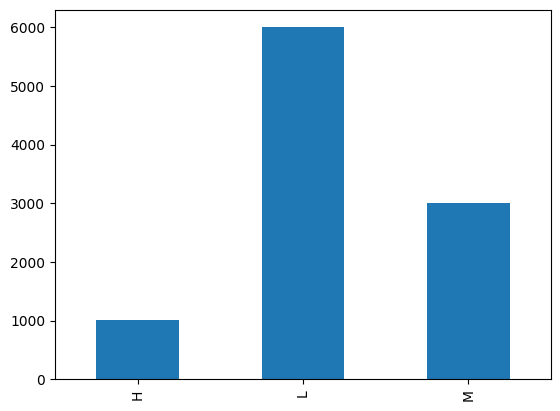

In [21]:
df["Type"].value_counts().sort_index().plot(kind='bar')

##### Target column과 categorical column 관계 분포 확인

In [22]:
pd.crosstab(df[target_column], df[list_categorical_columns[0]])

Type,H,L,M
Machine failure,,,
0,982,5765,2914
1,21,235,83


<AxesSubplot:xlabel='Machine failure'>

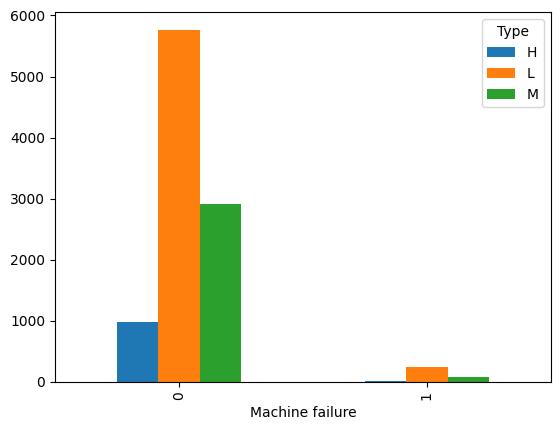

In [23]:
# categorical column과 dependent data(target column) 분포 분석
df_poutcome_dependent = pd.crosstab(df[target_column], df[list_categorical_columns[0]])
df_poutcome_dependent.plot(kind='bar')

# 애초에 target_column(y) 비중이 다르기 때문에, 아래와 같이 count 수를 비교하는 것은 데이터 분포를 파악하는데 적합하지 않음

In [24]:
pd.crosstab(df[target_column], df[list_categorical_columns[0]], normalize="index")

Type,H,L,M
Machine failure,,,
0,0.101646,0.596729,0.301625
1,0.061947,0.693215,0.244838


<AxesSubplot:xlabel='Machine failure'>

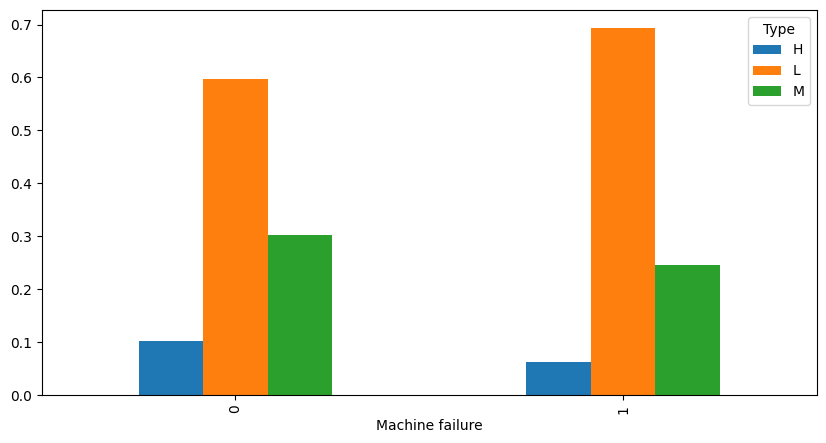

In [25]:
df_poutcome_dependent_ratio = pd.crosstab(df[target_column], df[list_categorical_columns[0]], normalize="index")
df_poutcome_dependent_ratio.plot.bar(figsize=(10,5))

##### 카이제곱 검정 (chisqaure-test)
*   카이제곱 검정은 두 범주형 변수에 대한 분석 방법. 
*   예를 들어, 성별에 따른 선호 영화 장르 비교 문제.
*   본 실습에서는 독립 변수중의 categorical column data와 y간의 관계를 검증. 
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/카이제곱_검정



##### 카이제곱 검정 추가 설명 : 3가지 유형
1.   적합도 검정 (Goodness of fit)
  - 변수 1개
  - 기존에 알려준 기준이 존재하는 검정 
  - 예시) 상자 안에 공 3개가 같은 비율로 알려져 있음. 공 100개를 뽑았을 때, 각 색의 비율이 구해짐. -> 기존에 알려진 공 비율 분포를 따르는지 검정
  - 귀무가설 : 변수 X의 관측분포와 기대 분포가 동일
  - 대립가설 : 변수 X의 관측분포와 기대분포가 동일

2.   독립성 검정 (Test of independence)
  - 변수 2개
  - 범주형 두 변수가 서로 연관되어 있는지 여부를 검정
  - 예시) 성별과 흡연 여부 관계를 알고 싶어서 200명을 추출하여 조사한 경우. 
  - 귀무가설 : 변수 X와 Y는 서로 독립
  - 대립가설 : 변수 X와 Y는 서로 독립이 아님
3.   동질성 검정 (Test of Homogeneity) 
  - 변수 2개
  - 범주형 두 변수의 관계를 알기 위한 검정은 아님
  - 각 그룹들이 동질한지 알고 싶은 검정
  - 예시) 남자와 여자 흡연율 차이가 있는지 흡연율을 조사한 후, 두 그룹의 흡연율이 같은지 여부를 검정
  - 귀무가설 : 각 그룹의 확률분포가 동일
  - 대립가설 : 각 그룹의 확률분포가 동일하지 않음




In [26]:
list_meaningful_column_by_chi = []
for column_name in list_categorical_columns:
  statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
  if pvalue <= 0.05:
    list_meaningful_column_by_chi.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

Type ,  13.75171680114931 ,  0.0010324110359454081
all categorical columns :  1
selected columns by chi :  1 ['Type']


##### Insight
1.   대부분의 카테고리 변수는 failure(target label)에 포함되는 값들이기 때문에 제거 필요. 
2.   Type은 종속변수에 유의미한 관계를 갖는것으로 판단할 수 있음



#### 2) Numeric Data Analysis

##### 불필요한 컬럼 확인

In [27]:
df[list_numeric_columns].nunique().sort_values()

Process temperature [K]     82
Air temperature [K]         93
Tool wear [min]            246
Torque [Nm]                577
Rotational speed [rpm]     941
dtype: int64

In [28]:
df[list_numeric_columns].describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


##### Column별 분포 확인

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


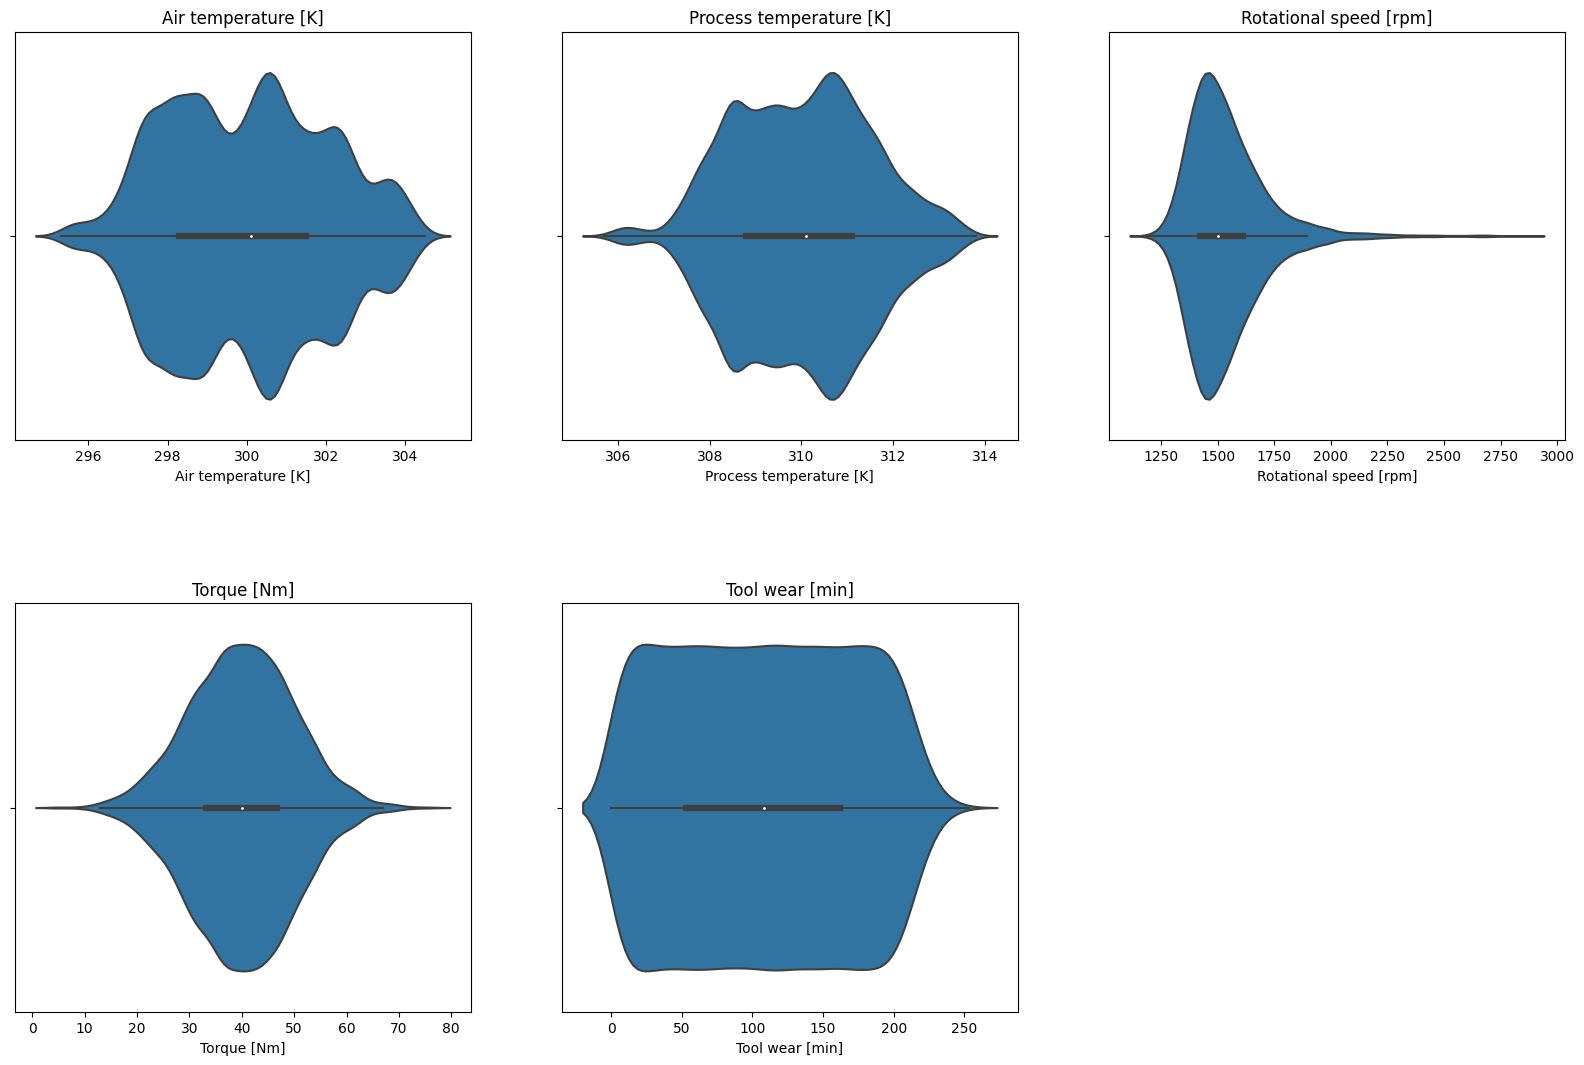

In [29]:
# numeric column 별 분포 확인
plt.figure(figsize=(20,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2,3,x)
    x = x+1
    sns.violinplot(x=column_name, data=df)
    plt.title(column_name)
plt.show()

In [30]:
for column_name in list_numeric_columns:
  print(column_name, "skew : ", skew(df[column_name]), "kur : ", kurtosis(df[column_name]) )
  
# 추후 scaling을 활용한 feature preprocessing의 필요성 확인

Air temperature [K] skew :  0.11425677871921017 kur :  -0.8361436902603159
Process temperature [K] skew :  0.015025013585136188 kur :  -0.5000844728185414
Rotational speed [rpm] skew :  1.9928720166048546 kur :  7.388649004260044
Torque [Nm] skew :  -0.009515168291199652 kur :  -0.01383393464278937
Tool wear [min] skew :  0.027288145044006527 kur :  -1.166753784684031


##### Correlation Analysis

<AxesSubplot:>

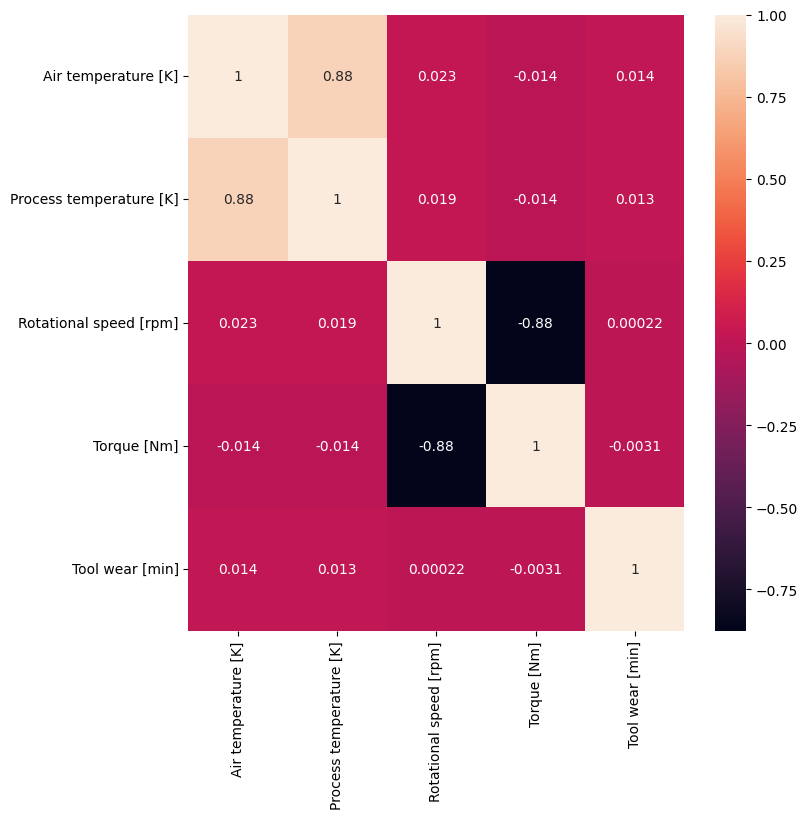

In [31]:
df_corr = df[list_numeric_columns + [target_column]].corr()
plt.figure(figsize=(8,8))
sns.heatmap(df_corr, annot=True)

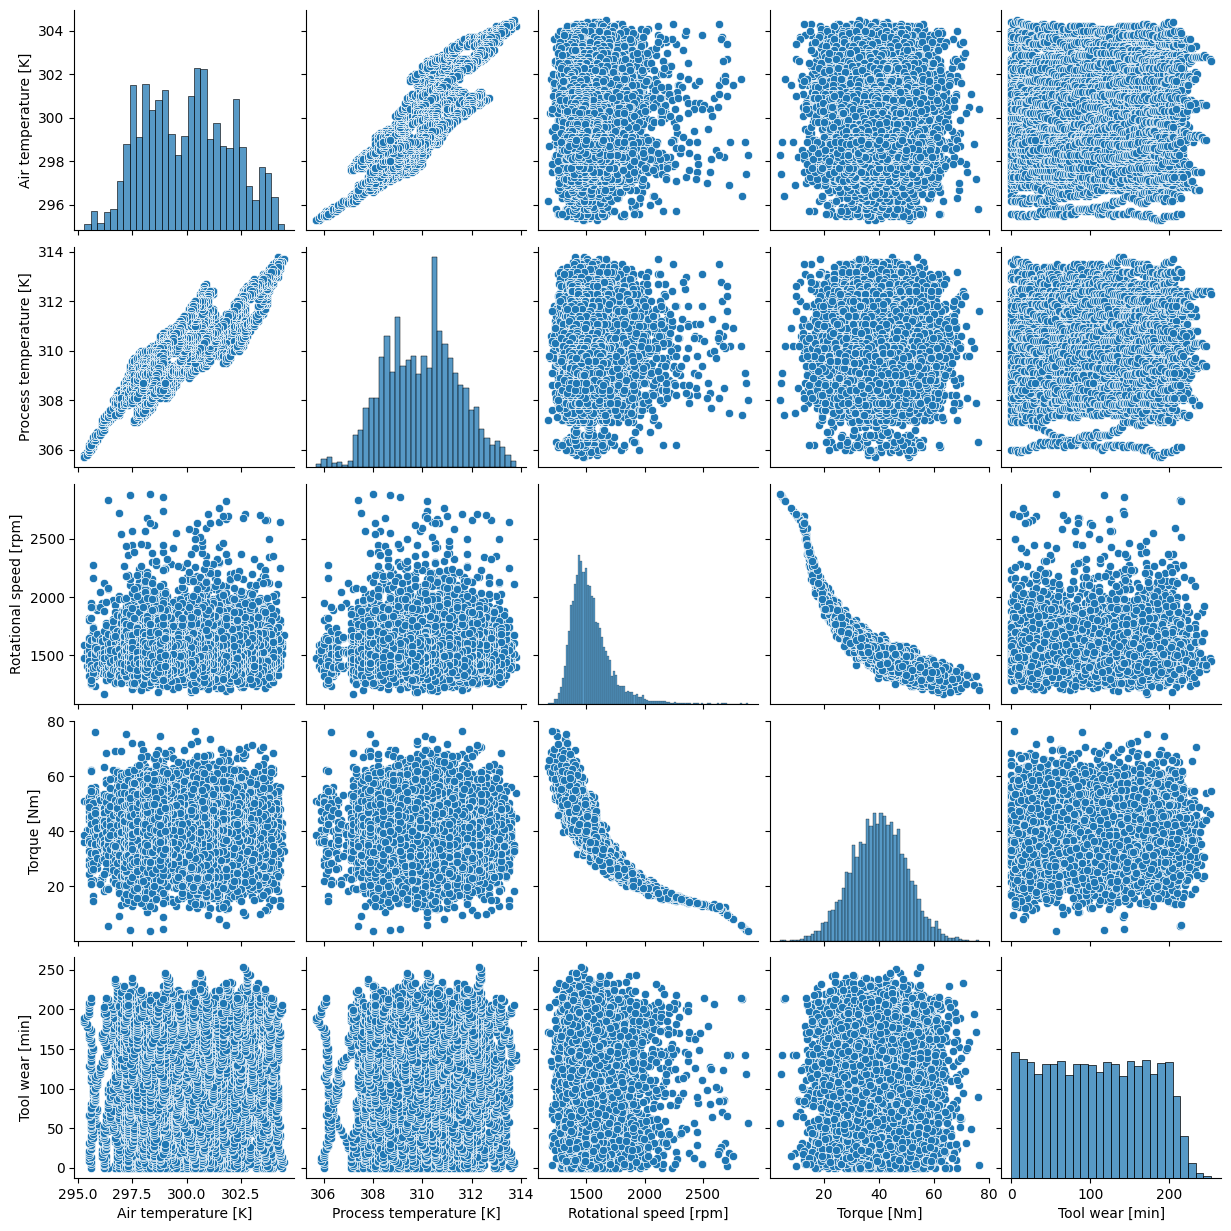

In [32]:
sns.pairplot(df[list_numeric_columns])

In [33]:
# Torque와 Rotational speed가 높은 상관관계를 갖음 
# 해당 상관관계의 pvalue 검정

statistic, pvalue = stats.pearsonr(df["Torque [Nm]"], df["Rotational speed [rpm]"])
print(statistic, pvalue)

-0.8750270862996061 0.0


##### VIF Analysis
-   일반적으로는는 10이상인 경우 다중공선성이이 있다고 가정. 본 실습에서는 20이상인 경우를 기준으로 잡음(너무 많은 데이터가 제거되면 비선형적인 관계를 갖고 있던 데이터 특성이 모두 제거 될 수 있으니 적정한 기준을 잡아 진행)
-   high correlation 컬럼을 제거하기 전에 한 번 더 검정을 진행 (doublecheck, 개인의 판단에 따라서 진행하지 않아도됨)

In [34]:
def caculate_vif(df_target):
  vif = pd.DataFrame()
  vif['VIF_Factor'] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  vif['Feature'] = df_target.columns
  return vif

df_vif = df[list_numeric_columns].copy()

In [35]:
df_vif_result = caculate_vif(df_vif)
df_vif_result

,VIF_Factor,Feature
0,87413.106376,Air temperature [K]
1,88285.242860,Process temperature [K]
2,315.329872,Rotational speed [rpm]
3,72.125192,Torque [Nm]
4,3.877244,Tool wear [min]


In [36]:
df_vif_result = caculate_vif(df_vif.drop(["Air temperature [K]","Rotational speed [rpm]"], axis=1))
df_vif_result

,VIF_Factor,Feature
0,19.994474,Process temperature [K]
1,17.075601,Torque [Nm]
2,3.876991,Tool wear [min]


In [37]:
# vif와 corrleation을 고려하여 두 개 데이터 제외하기로 결정 
list_numeric_columns.remove("Air temperature [K]")
list_numeric_columns.remove("Rotational speed [rpm]")

In [38]:
list_numeric_columns

['Process temperature [K]', 'Torque [Nm]', 'Tool wear [min]']

##### Target Column과 numeric Column 관계 분포 확인

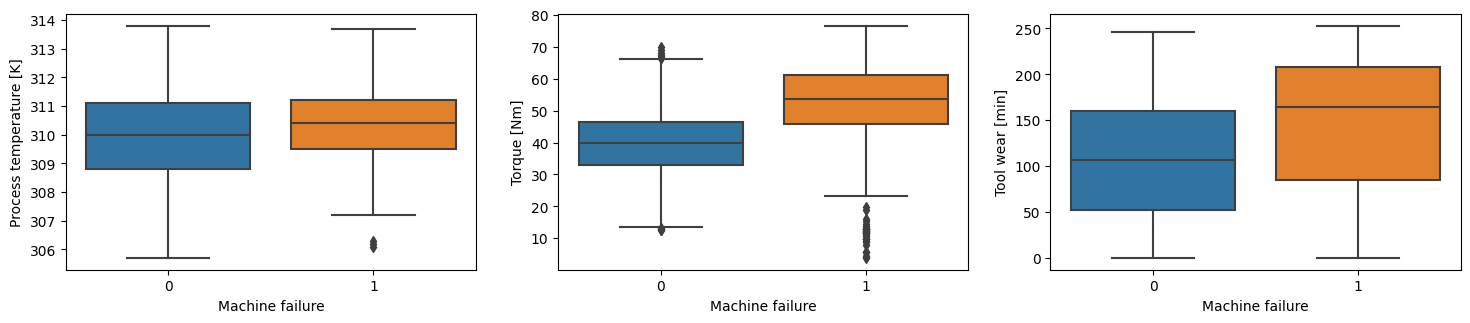

In [39]:
plt.figure(figsize=(18,12))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(4,3,x)
    x = x + 1
    sns.boxplot(data=df,x=target_column,y=column_name)
plt.show()

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 failure 에 따른 numeric column data 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)





정규성 검정
*   귀무가설 : 모집단의 분포는 정규 분포이다
*   검정 방법 : Shpiro-Wilks Test, QQPlot(눈으로 확인)
*   p-value < 0.05이면, 귀무가설 기각 (기각하지 못하여야 정규성을 만족)

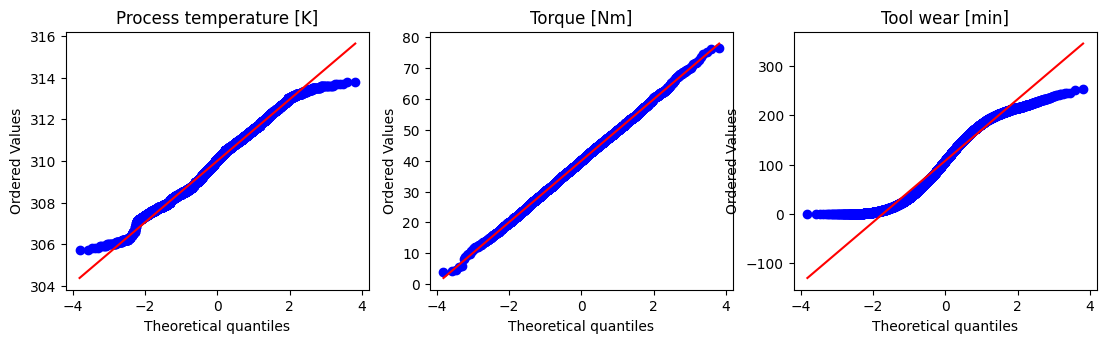

In [40]:
# numeric column 정규성 확인
plt.figure(figsize=(18,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(3,4,x)
    x = x+1
    stats.probplot(df[column_name], dist=stats.norm, plot=plt)
    plt.title(column_name)
plt.show()

In [41]:
list_column_normality = []
for column_name in list_numeric_columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue >= 0.05:
    list_column_normality.append(column_name)
  print(column_name, ", statistic : ",statistic,", pvalue : ", pvalue)
print("정규성 만족하는 column 수 : ", len(list_column_normality))

Process temperature [K] , statistic :  0.9923496842384338 , pvalue :  9.738203885027511e-23
Torque [Nm] , statistic :  0.9997753500938416 , pvalue :  0.38203656673431396
Tool wear [min] , statistic :  0.9599096179008484 , pvalue :  0.0
정규성 만족하는 column 수 :  1


p-value may not be accurate for N > 5000.


정규성을 만족하는 변수만 추가적인 검정을 진행
*   정규성을 만족하지 못하므로, 등분산성 검정이 필요가 없음 (등분산성은 정규성을 전제)
*   일원분산분석을 통한 numeric data 검정 불가 

In [42]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html
list_target_unique = df[target_column].unique()
list_by_quality_value = []
for quality_value in list_target_unique:
  df_tmp = df[df[target_column] == quality_value][column_name]
  list_by_quality_value.append(np.array(df_tmp))

bartlett(*list_by_quality_value)


BartlettResult(statistic=15.012150829301168, pvalue=0.00010682116683995105)

등분산성을 만족하지 못하므로 일원분산분석을 진행할수 없음

##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐 

In [43]:
list_target_unique = df[target_column].unique()
list_meaningful_column_by_kruskall = []

for column_name in list_numeric_columns:
  list_by_quality_value = []
  for quality_value in list_target_unique:
      df_tmp = df[df[target_column] == quality_value][column_name].dropna()
      list_by_quality_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_quality_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all numerical columns : ", len(list_numeric_columns))
print("selected columns by anova : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

Process temperature [K] ,  15.955233602795756 ,  6.485821109968368e-05
Torque [Nm] ,  286.98060634931943 ,  2.2618643221156073e-64
Tool wear [min] ,  103.27563708744904 ,  2.916174538620708e-24
all numerical columns :  3
selected columns by anova :  3 ['Process temperature [K]', 'Torque [Nm]', 'Tool wear [min]']


##### Insight
1.   y(종속 변수)와 numerical data는 모두 유의미한 관계를 갖음 (크루스칼 왈리스 검정)
2.   상관관계와 vif분석에서 제거하기로 결정한 변수 2개이며 제거 완료



### 2-4 EDA with pandas_profiling 

In [44]:
df.profile_report().to_file("Data/data_eda_with_pandasprofiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##### Insight
*   EDA를 진행하며 최종 선택된 컬럼 데이터 수 : 4 (기존 14개)
*   categorical columns : 1 (target 포함, 기존 9개)
*   numerical columns : 3 (기존 5개)


## 3. Data Processing 2 

### 3-1 Missing Values

In [45]:
df.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
dtype: int64

### 3-2 Feature Selection
*   카이제곱 검정을 통과한 categorical 선택
*   kruskall 검정 통과한 numerical 선택
*   correlation, vif 검정에서 상관관계가 높다고 판단한 numericla data 제거



In [46]:
df_fs = df[list_meaningful_column_by_chi + list_numeric_columns + [target_column]]
df_fs.head(2)

,Type,Process temperature [K],Torque [Nm],Tool wear [min],Machine failure
0,M,308.6,42.8,0,0
1,L,308.7,46.3,3,0


### 3-3 Feature Transformation

In [47]:
Y = df_fs[target_column]
X = df_fs.drop([target_column], axis=1)

In [48]:
Y

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Machine failure, Length: 10000, dtype: object

##### Label Encoding

In [49]:
Y = Y.astype("int64")

##### Feature Scaling
*   Standardization과 MinMaxScaling은 다른 것.
*   MinMaxScaling은 [0,1]로 값을 scaling 하는 것 (예 sklearn의 MinMaxScaler())
*   Standardization은 정규분포의 표준화를 활용하여 scaling하는 것 (예 sklearn의 StandardScaler())



In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Process temperature [K]  10000 non-null  float64
 2   Torque [Nm]              10000 non-null  float64
 3   Tool wear [min]          10000 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 312.6+ KB


In [51]:
list_categorical_columns = list(X.select_dtypes(include=['object']).columns)
list_numeric_columns = list(X.select_dtypes(include=['float64','int64']).columns)
print(len(list_categorical_columns))
print(len(list_numeric_columns))

1
3


In [52]:
X.head(1)

,Type,Process temperature [K],Torque [Nm],Tool wear [min]
0,M,308.6,42.8,0


In [53]:
scaler = MinMaxScaler()
X.loc[:, list_numeric_columns] = scaler.fit_transform(X[list_numeric_columns])
X.head(1)

,Type,Process temperature [K],Torque [Nm],Tool wear [min]
0,M,0.358025,0.535714,0.0


##### One-hot Encoding for categorical column data

In [54]:
X_base = pd.get_dummies(X)
X_base.head(1)

,Process temperature [K],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
0,0.358025,0.535714,0.0,0,0,1


### 3-4 Sampling
*   이번 실습에서는 두 가지 oversampling 2가지 기법 활용하여 Model optimization 진행
*   SMOTE : Synthetic Minority Overf-sampling Technique. minority class에서 synthetic sampling을 생성하는 방법. 특정 minority class A에서 knn 기준으로 가까운 minority class Set K를 생성하고, A와 Set K 사이 간에 새로운 관측치를 생성하는 기법.
*   SVMSMOTE : SMOTE + SVM



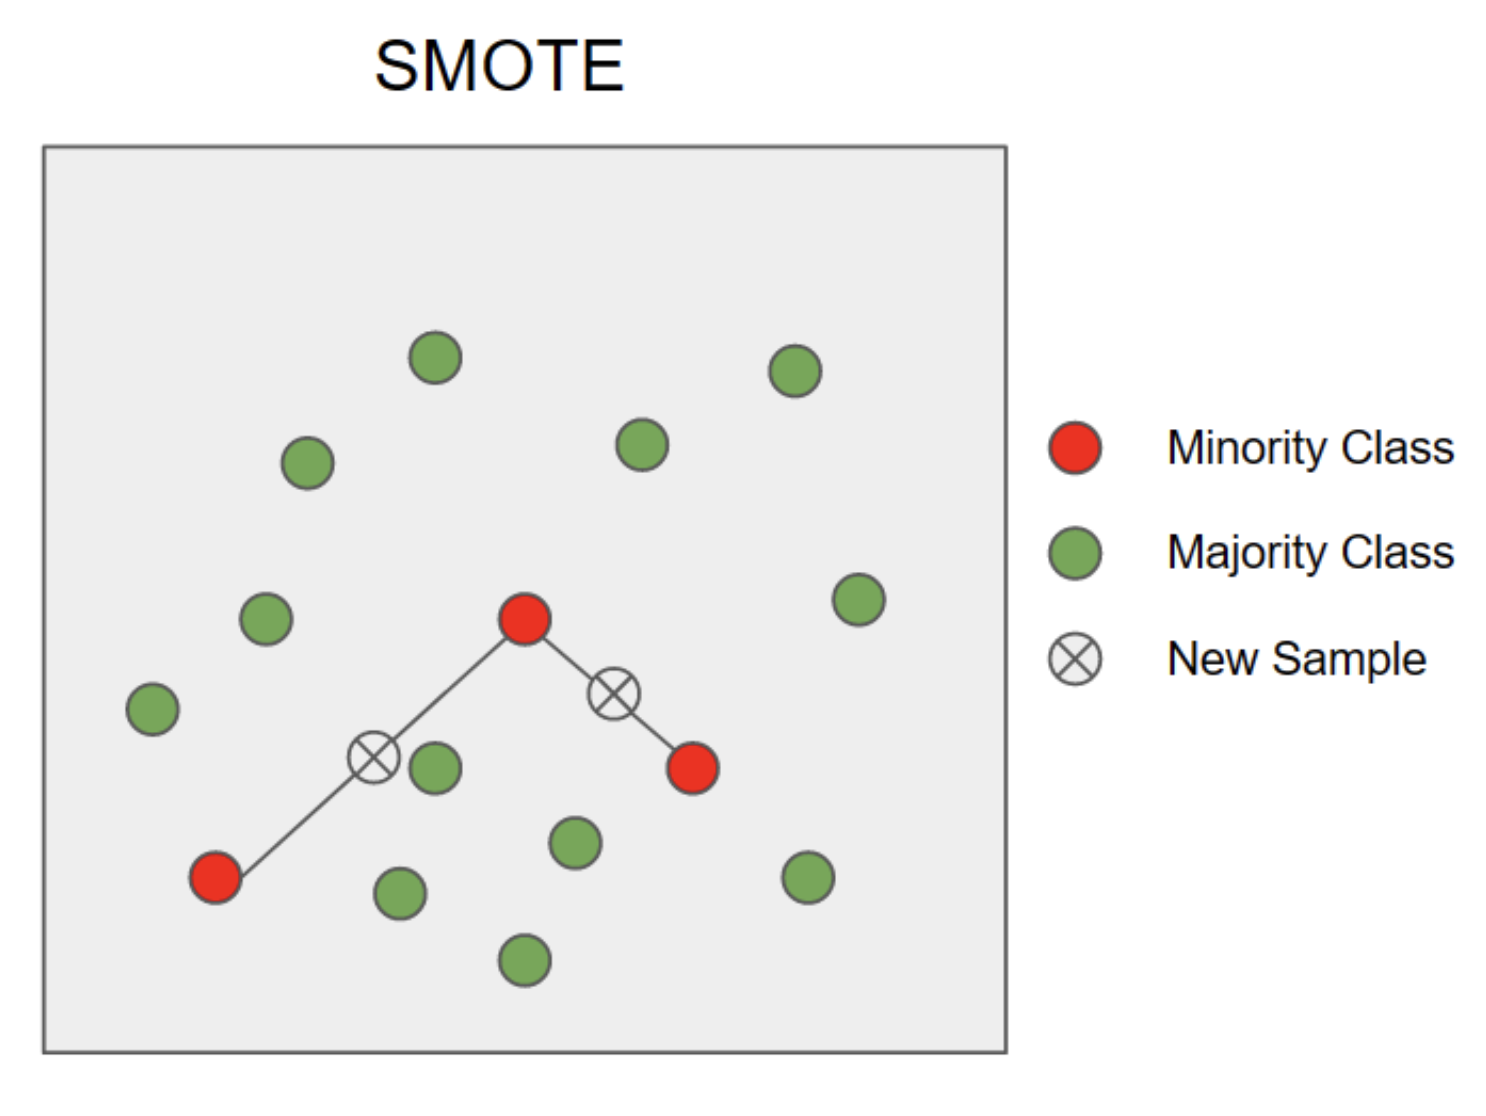

In [56]:
Image("Img/sampling.png")

In [57]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y, test_size=0.2, stratify=Y)

SMOTE

In [58]:
sm = SMOTE(random_state=random_state)
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

In [59]:
y_train.value_counts()

0    7729
1     271
Name: Machine failure, dtype: int64

In [60]:
y_sm_sampling.value_counts()

0    7729
1    7729
Name: Machine failure, dtype: int64

SVMSMOTE

In [61]:
svm_sm = SVMSMOTE(random_state=random_state)
X_svm_sampling, y_svm_sampling = svm_sm.fit_resample(X_train, y_train)

In [62]:
y_train.value_counts()

0    7729
1     271
Name: Machine failure, dtype: int64

In [63]:
y_svm_sampling.value_counts()

0    7729
1    7729
Name: Machine failure, dtype: int64

SMOTE와 SVMSMOTE가 동일한 수의 Sampling을 진행했지만, 알고리즘이 다르기 때문에 모델 학습 결과에는 다른 결과를 기대할 수 있음.

### 3-3 Summary
##### 최종 생성 Feature는 아래와 같은 특성을 가짐 
1.   Feature Selection by Chi-test, correlation and kruskal-test 
2.   Feature Transformation
3.   Sampling (oversampling)

##### Feature 종류
1.   X_base, Y (No sampling, imbalanced data)
2.   X_sm_sampling, Y_sm_sampling (smote oversampling)
3.   X_svm_sampling, Y_svm_sampling (svm smote oversampling)


## 4. Model Analysis
1.   Base model without sampling
2.   Model Optimization without sampling
3.   Isolation Forest Optimization without sampling
4.   model optimization with SMOTE Oversampling
5.   model optimization with SVMSMOTE Oversampling

In [64]:
list_model_type = []
list_model_best_params = []
list_model_f1score = []
cv = 3
n_iter_randomsearch = 16

### 4-1. Base model without sampling

In [65]:
X_train_npy = np.array(X_train)
y_train_npy = np.array(y_train)

In [66]:
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train_npy, y_train_npy)

3

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html


*   average에 따라서 precision, recall, f1score 값이 크게 변화한다. 



In [67]:
list_fold_result = []
for i, (train_index, test_index) in enumerate(skf.split(X_train_npy, y_train_npy)):
  X_train_cv, X_test_cv = X_train_npy[train_index], X_train_npy[test_index]
  y_train_cv, y_test_cv = y_train_npy[train_index], y_train_npy[test_index]
  rf_clf = RandomForestClassifier()
  rf_clf.fit(X_train_cv, y_train_cv)
  y_prd_test = rf_clf.predict(X_test_cv)
  y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]
  prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average="macro")
  score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average="macro")
  print(i, " precision, recall, f1score : ", prf_score_test)
  print(i, " roc_auc_score : ", score_test)

  y_prd_validation = rf_clf.predict(X_validation)
  y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]
  prf_score_validation = precision_recall_fscore_support(y_validation, y_prd_validation, average="macro")
  score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average="macro")
  print("validation : precision, recall, f1score : ",prf_score_validation)
  print("validation : roc_auc_score : ",score_validation)
  list_fold_result.append(prf_score_validation[2])

average_f1score = np.mean(list_fold_result)
print("average f1score : ",average_f1score)
list_model_type.append("Base model without sampling")
list_model_best_params.append({})
list_model_f1score.append(average_f1score)

0  precision, recall, f1score :  (0.9488130716267599, 0.6883068167119389, 0.76205108507778, None)
0  roc_auc_score :  0.9013366101841072
validation : precision, recall, f1score :  (0.9145219725554241, 0.6680824503714529, 0.7358312554754364, None)
validation : roc_auc_score :  0.8779723846060163


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


1  precision, recall, f1score :  (0.9029328334688055, 0.707238413760153, 0.7715034923292354, None)
1  roc_auc_score :  0.8857799808886765
validation : precision, recall, f1score :  (0.9114583333333333, 0.6972354159054927, 0.764102564102564, None)
validation : roc_auc_score :  0.8997495737425405


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


2  precision, recall, f1score :  (0.8802905225499368, 0.6595583160800552, 0.7217182146179855, None)
2  roc_auc_score :  0.8850651311249136
validation : precision, recall, f1score :  (0.8993045494059693, 0.6678236511996103, 0.7331796448087431, None)
validation : roc_auc_score :  0.9066952868103764
average f1score :  0.7443711547955812


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


<AxesSubplot:>

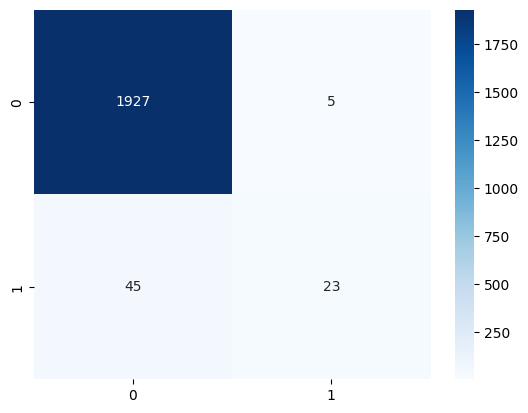

In [68]:
cm = pd.DataFrame(confusion_matrix(y_validation,y_prd_validation))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

### 4-2. model optimization with base feature

In [69]:
def plot_roc_auc(y_true, y_prd_proba):
  fpr, tpr, _ = roc_curve(y_true,  y_prd_proba)
  auc = roc_auc_score(y_true, y_prd_proba)
  plt.figure(figsize=(7,7))
  plt.plot(fpr,tpr,label="auc="+str(auc))
  plt.legend(loc=4)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()

In [70]:
def model_learning_with_randomsearch(model, hyper_parameter, X, Y, metric="roc_auc_ovr_weighted"):
  random_cv_opt = RandomizedSearchCV(estimator=model, param_distributions=hyper_parameter, n_iter=n_iter_randomsearch, cv = cv, random_state=random_state, scoring=metric, verbose=1)
  random_cv_opt.fit(X, Y)
  y_prd = random_cv_opt.predict(X_validation)
  prf_score = precision_recall_fscore_support(y_validation, y_prd, average="macro")
  y_prd_proba = random_cv_opt.predict_proba(X_validation)[:,-1]
  score = roc_auc_score(y_validation, y_prd_proba, average="macro")
  print('validation -> best model hyper-parameter : ', random_cv_opt.best_params_)
  print("validation -> precision, recall, f1score : ", prf_score)
  print("validation -> roc_auc_score : ", score)

  cm = pd.DataFrame(confusion_matrix(y_validation,y_prd))
  sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

  return random_cv_opt.best_params_, prf_score, score

Fitting 3 folds for each of 16 candidates, totalling 48 fits
validation -> best model hyper-parameter :  {'max_features': 0.8, 'max_depth': 10, 'class_weight': 'balanced'}
validation -> precision, recall, f1score :  (0.6589722337339411, 0.7189897698209718, 0.683418314730162, None)
validation -> roc_auc_score :  0.9232089574960419


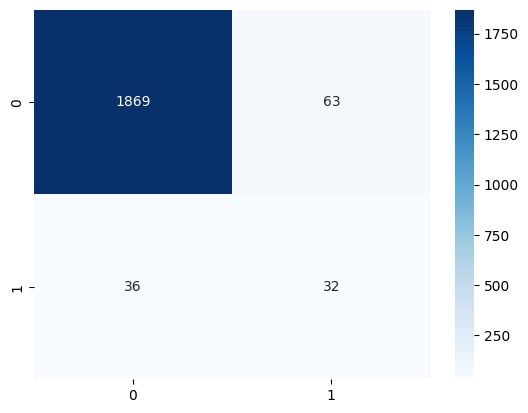

In [71]:
hyper_params_rlf = {
    "max_depth" : [8, 10, 15, 20],
    "class_weight" : ["balanced", "balanced_subsample"],
    "max_features" : [0.7, 0.8, 0.9]
              }
params, prf_score, score = model_learning_with_randomsearch(RandomForestClassifier(), hyper_params_rlf, X_train, y_train)
list_model_type.append("model optimization without sampling")
list_model_best_params.append(params)
list_model_f1score.append(prf_score[2])

### 4-3. Isolation Forest Optimization without sampling

In [72]:
def change_prediction_result(y_prd):
  return np.where(y_prd == 1, 0, 1)

if_clf = IsolationForest(n_estimators=100, max_samples='auto', max_features=0.9)
if_clf.fit(X_train)
y_prd = if_clf.predict(X_validation)

In [73]:
y_prd_changed = change_prediction_result(y_prd)
prf_score = precision_recall_fscore_support(y_validation, y_prd_changed, average="macro")

In [74]:
prf_score

(0.5192278784911463, 0.6363110461575935, 0.44063854217973847, None)

<AxesSubplot:>

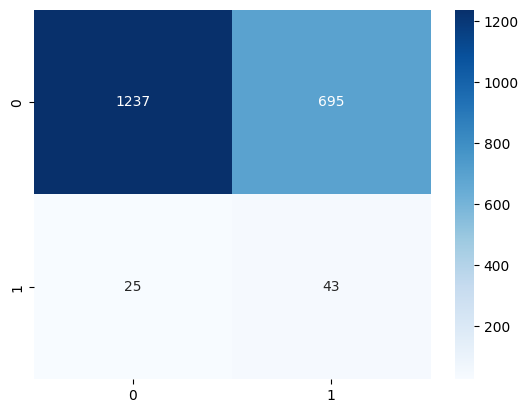

In [75]:
cm = pd.DataFrame(confusion_matrix(y_validation,y_prd_changed))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

In [76]:
list_model_type.append("Isolation Forest Optimization without sampling")
list_model_best_params.append({})
list_model_f1score.append(prf_score[2])

### 4-4. model optimization with SMOTE Oversampling

Fitting 3 folds for each of 16 candidates, totalling 48 fits
validation -> best model hyper-parameter :  {'max_features': 0.8, 'max_depth': 20, 'class_weight': 'balanced'}
validation -> precision, recall, f1score :  (0.631345785440613, 0.7672025331871879, 0.6712558028331773, None)
validation -> roc_auc_score :  0.9298463950797711


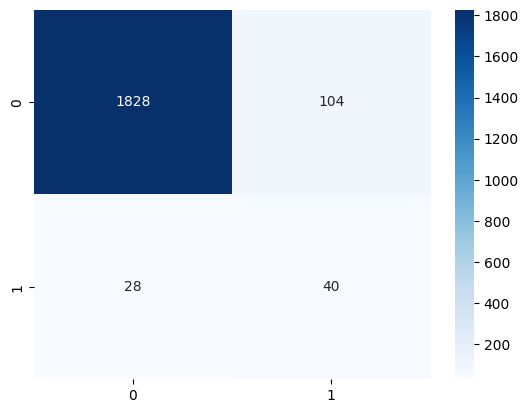

In [77]:
params, prf_score, score = model_learning_with_randomsearch(RandomForestClassifier(), hyper_params_rlf, X_sm_sampling, y_sm_sampling)
list_model_type.append("model optimization with smote oversampling")
list_model_best_params.append(params)
list_model_f1score.append(prf_score[2])

### 4-5. model optimization with SVMSMOTE sampling

Fitting 3 folds for each of 16 candidates, totalling 48 fits
validation -> best model hyper-parameter :  {'max_features': 0.8, 'max_depth': 20, 'class_weight': 'balanced_subsample'}
validation -> precision, recall, f1score :  (0.6929632667942758, 0.757824869078066, 0.7200520833333334, None)
validation -> roc_auc_score :  0.9179530507855316


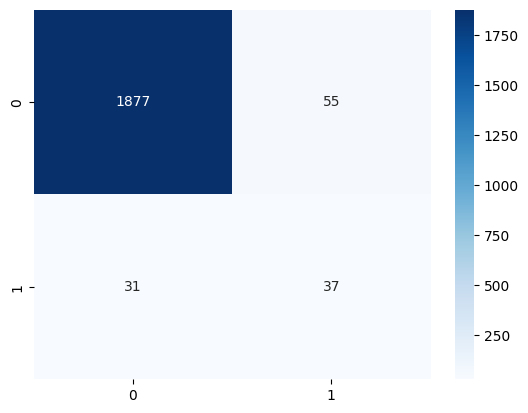

In [78]:
params, prf_score, score = model_learning_with_randomsearch(RandomForestClassifier(), hyper_params_rlf, X_svm_sampling, y_svm_sampling)
list_model_type.append("model optimization with smoteenn combined oversampling")
list_model_best_params.append(params)
list_model_f1score.append(prf_score[2])

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


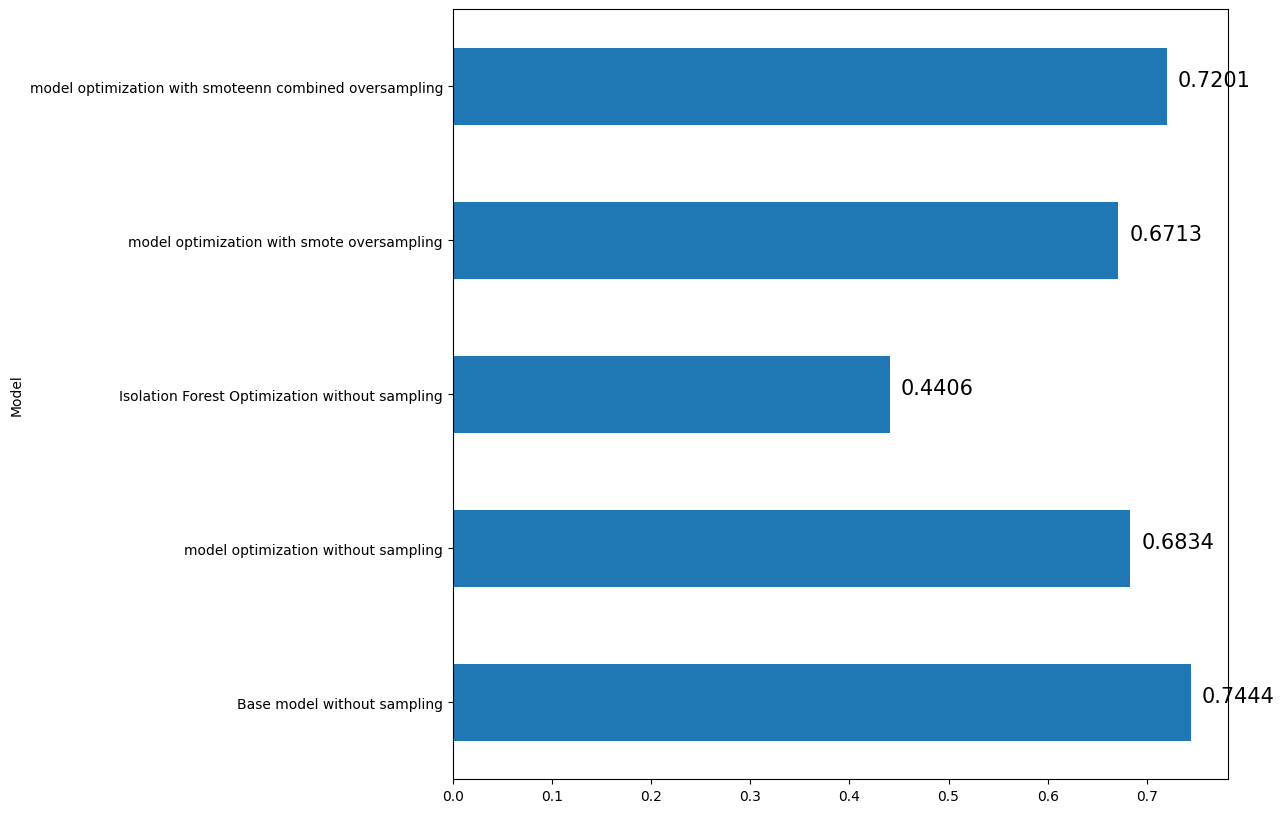

In [79]:
df_metric = pd.DataFrame({'Model':list_model_type, 'f1score_macro':list_model_f1score})
ax = df_metric.plot.barh(x='Model', y='f1score_macro', rot=0, figsize=(10,10), legend=False)
for bar in ax.patches:
    ax.annotate(format(bar.get_width(), '.4f'),
                   (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                   size=15, xytext=(8, 0),
                   textcoords='offset points')

### 4.6 Model Metrics

In [80]:
# reproduction
rf_final = RandomForestClassifier()
rf_final.fit(X_train, y_train)

RandomForestClassifier()

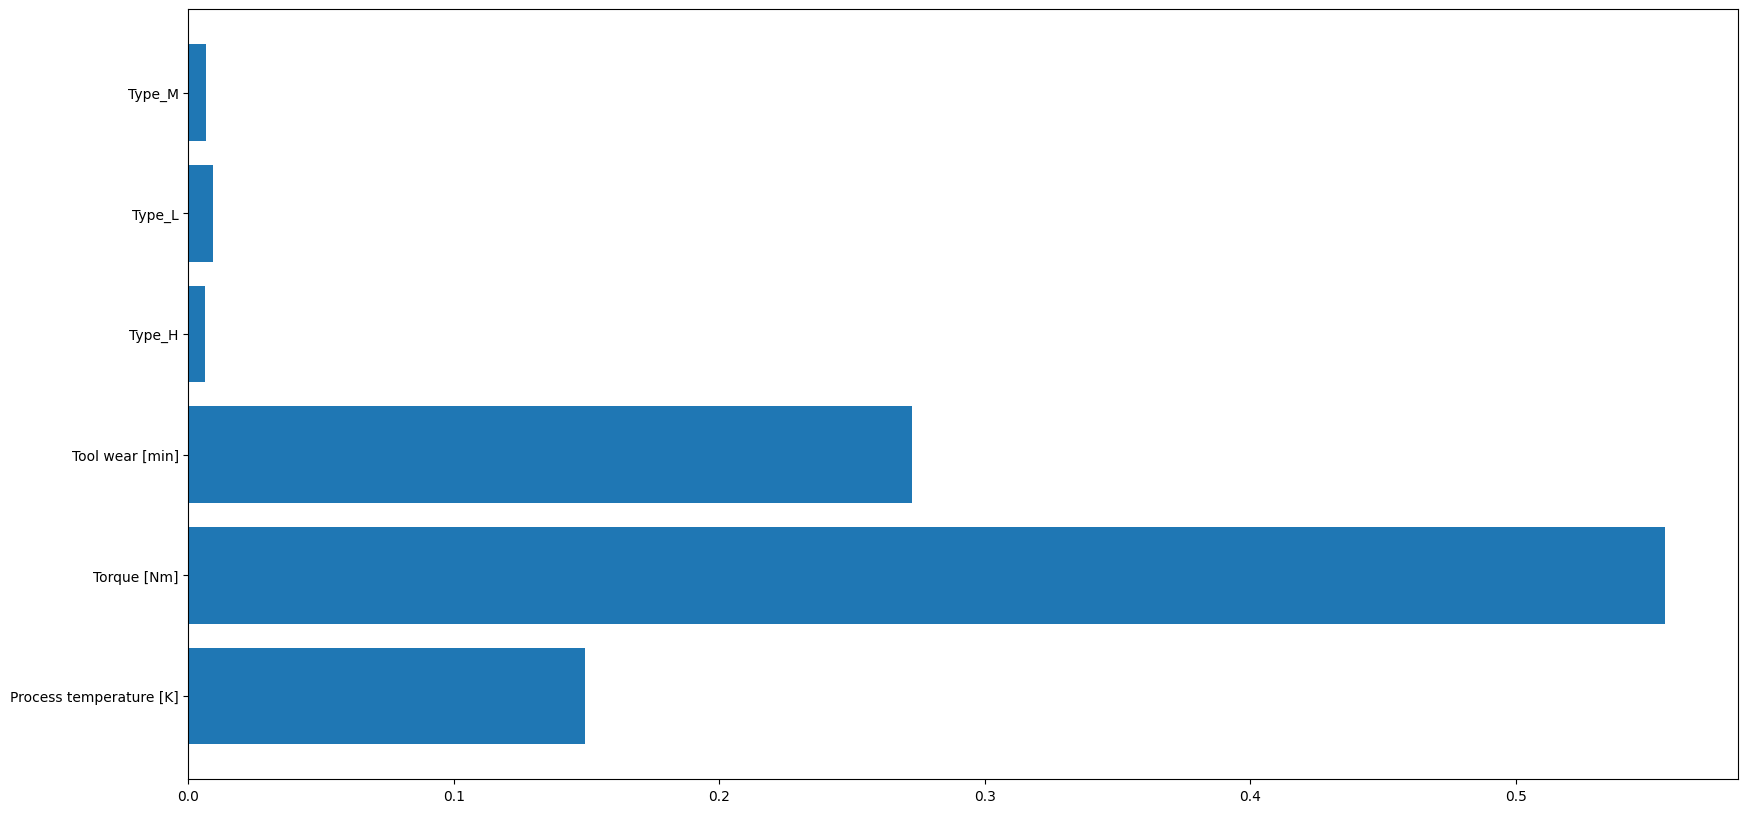

In [81]:
plt.figure(figsize=(20,10))
ax = plt.barh(list(X_validation.columns),rf_final.feature_importances_)

##### Shapley Value
*   게임 이론에 근거해서 만들어진 값 (https://ko.wikipedia.org/wiki/게임이론)
*   하나의 특성에 대한 중요도를 알기위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 변화를 분석해서 얻어낸 값 
*.  Explainable AI 
*   https://en.wikipedia.org/wiki/Shapley_value



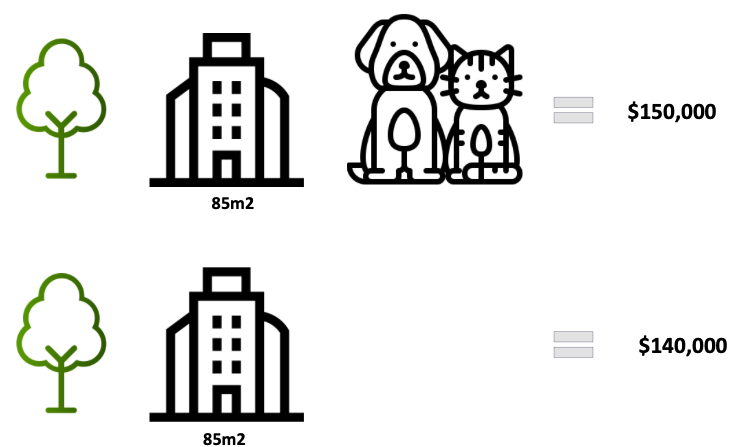

In [82]:
Image("Img/shapley_value.png")

In [83]:
explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_validation)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


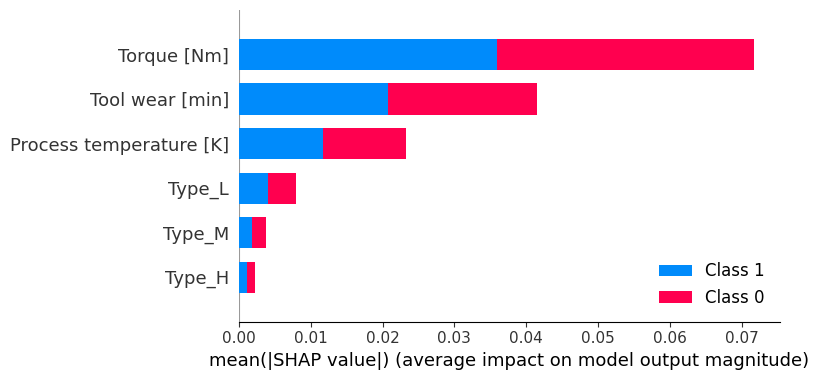

In [84]:
shap.summary_plot(shap_values, X_validation)